In [90]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt 
import cas as cas
import importlib
import pickle

The goal of this notebook is to obtain the custom circuit fluxes to run an annealing process. In particular we are interested in solving the Traveling Salesman Problem (TSP).

# Building block objects: Circuit elements

We are going to use two main types of circuits elements: the Capacitively Shunted Flux Qubit and Couplers. The library we are using have their own methods and attributes that can be used in other classes. At first we are going to inspect these elements and how to use them. 

In [91]:
# qubit parameters and definition
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

# coupler
i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler = cas.Coupler(i_sigma, c_sigma, lc, d)


/Users/enriquenb/opt/anaconda3/envs/Qilimanjaro-ETH-Hackathon/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


First, we investigate all the methods that the qubit object has:

In [62]:
import inspect
method_names = [attr for attr in dir(qubit) if inspect.ismethod(getattr(qubit, attr))]
method_names

['__init__',
 '_c',
 '_residuals',
 'evolve_se',
 'get_fluxes',
 'get_h',
 'get_ip',
 'get_ising',
 'get_low_e',
 'get_pauli',
 'get_pauli_low_e',
 'get_povm',
 're_init']

In [63]:
print(qubit.get_ising.__doc__)

Calculates the Ising coefficients for single qubit.
        See arXiv:1912.00464 for more details.

        Arguments
        ---------
        phi_x : float
            x (barrier) bias phase (not flux)
            Should be in the range -2pi <= phi_x <= 2pi
        phi_z : float
            z (tilt) bias phase (not flux)
            Should be in the range 0 <= phi_z <= 2pi

        Returns
        -------
        ising : array
            sigma_x and sigma_z coefficients
            dim=(1, 2)
        basis : ndarray
            computational basis, which is a linear combination of first two
            eigenstates. First column is |0>, second column is |1>
            dim=(2, nmax)
        


We obtain the Ising coefficients of a single qubit for given circuit biases:

In [64]:
ising, basis = qubit.get_ising(phi_x=0.72*2*np.pi, phi_z=0.003*2*np.pi)

ising/2/np.pi

array([1.26307414, 0.52212011])

We can also obtain the Hamiltonian for the coupler element

In [65]:
print(coupler.get_h.__doc__)

Builds the coupler Hamiltonian.

        Arguments
        ---------
        phi_x : float
            x (barrier) bias phase (not flux)
        phi_z : float
            z (tilt) bias phase (not flux)

        Returns
        -------
        ham : ndarray
            circuit Hamiltonian
            dim=(nmax, nmax)
        


In [66]:
coupler.get_h(phi_x=0.8*2*np.pi, phi_z = 0.5*2*np.pi)

array([[-1.34893620e+03+0.00000000e+00j,  5.52329704e-14+0.00000000e+00j,
         1.06627368e+02-1.09892026e-30j, ...,
        -1.44220983e-65+2.18305393e-58j, -5.88185463e-51-4.16203000e-75j,
         3.73429529e-68-3.09421384e-60j],
       [ 5.52329704e-14+0.00000000e+00j, -8.02238540e+02+0.00000000e+00j,
         7.37452967e-14+7.91855499e-14j, ...,
         1.62797609e-47+3.53677935e-72j, -9.96578278e-65+3.95119063e-57j,
        -4.11729824e-50-4.25790183e-74j],
       [ 1.06627368e+02+1.09892026e-30j,  7.37452967e-14-7.91855499e-14j,
        -2.63969295e+02+0.00000000e+00j, ...,
         1.92385664e-61-1.34038680e-54j,  7.95545779e-47+2.89756104e-71j,
        -4.93307487e-64+2.18544046e-56j],
       ...,
       [-1.44220983e-65-2.18305393e-58j,  1.62797609e-47-3.53677935e-72j,
         1.92385664e-61+1.34038680e-54j, ...,
         1.88835210e+04+0.00000000e+00j, -8.48629494e-14+1.58371100e-13j,
         7.65343151e+02+1.75827241e-29j],
       [-5.88185463e-51+4.16203000e-75j, -9.

# Solving the TSP with nine qubits
## Creating the circuit object

Here we consider a chain of nine qubits that are coupled via eight tunable couplers, the sign of coupling parameter depends on whether the qubits are coupled ferromagnetically (negative ZZ sign) or anti-ferromagnetically (positive ZZ sign). First, let us create the qubit and coupler objects, using typical parameters. Here we use symmetric junctions with d=0.

In [92]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
nqubits = 9

elements = []

for i in range(nqubits):
    elements.append(cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d))
    if i != nqubits -1 : 
        elements.append(cas.Coupler(i_sigma, c_sigma, lc, d))

'''
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit2 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit3 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit4 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit5 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit6 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit7 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit8 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

coupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler12 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler23 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler34 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler45 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler56 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler67 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler78 = cas.Coupler(i_sigma, c_sigma, lc, d)
'''


'\nqubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\nqubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\nqubit2 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\nqubit3 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\nqubit4 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\nqubit5 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\nqubit6 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\nqubit7 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\nqubit8 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)\n\ncoupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)\ncoupler12 = cas.Coupler(i_sigma, c_sigma, lc, d)\ncoupler23 = cas.Coupler(i_sigma, c_sigma, lc, d)\ncoupler34 = cas.Coupler(i_sigma, c_sigma, lc, d)\ncoupler45 = cas.Coupler(i_sigma, c_sigma, lc, d)\ncoupler56 = cas.Coupler(i_sigma, c_sigma, lc, d)\ncoupler67 = cas.Coupler(i_sigma, c_sigma, lc, d)\ncoupler78 = cas.Coupler(i_sigma, c_sigma, lc, d)\n'

After creating the circuit objects, we should put them in a list elements that holds them and essentially assigns indexes to them

In [93]:
elements = [qubit0, coupler01, qubit1, coupler12, qubit2, coupler23, qubit3, coupler34, qubit4, coupler45, qubit5, coupler56, qubit6, coupler67, qubit7, coupler78, qubit8]

print(len(elements))

17


Having our qubits and coupler in this list, we will now have to set the mutuals between them to construct the mutual matrix m_mat between them. For that, if 
elements[i] and elements[i] circuit elements are coupled via a mutual inductance of m, then for the mutual matrix we should have m_mat[i, j] = m_mat[j, i] = -m (notice the negative sign). Note that the size of (both of axis of the) mutual matrix is the same as the size of the elements. Therefore for a chain configuration we have

In [94]:
m = 65; m_mat = m*np.diag([1 for i in range(16)], k = 1)

# Look how m may change

m_mat = -(m_mat + m_mat.T)

print(m_mat)

[[  0 -65   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [-65   0 -65   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 -65   0 -65   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 -65   0 -65   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 -65   0 -65   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 -65   0 -65   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 -65   0 -65   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 -65   0 -65   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 -65   0 -65   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 -65   0 -65   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 -65   0 -65   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 -65   0 -65   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 -65   0 -65   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 -65   0 -65   0   0]
 [  0 

In [70]:
print(np.shape(m_mat))

(17, 17)


For our case we have chosen to implement a chain of qubits whose mutual inductance is always the same for all elements

The last part is to choose a truncation size for the circuit elements. This assigns a truncation size to each object in the elements, which means how many low-energy eigenstates and eigenvalues of the system to keep when calculating the joint Hamiltonian of the system (or subsystem). Here I use a smaller truncation for couplers compared to qubits, cause couplers have higher frequencies.

In [96]:
trunc_vec = np.array([6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6])

print(len(trunc_vec))

17


We have now all the required elements to create our circuit object which we'll use for all the calculations

In [97]:
circuit = cas.AnnealingCircuit(elements, m_mat, trunc_vec)

# Calculating Ising schedules for given circuit biases

To calculate the schedules using the circuit biases, we first have to construct a dictionary of the circuit fluxes. This dictionary will have a key named `points` which simply is the number of points used for the flux schedules.
For circuit element i(`elements[i]`), the x and z biases should have keys of `phix_i` and `phiz_i` respectively. This keys then are assigned to an array of flux points. The input for circuit biases are phase, i.e. $\phi = \frac{\Phi}{\Phi_0} 2 \pi$ where $\phi$ is the phase and $\Phi$ is the magnetic flux. 

Note that we use the annealing regino near $\Phi_z = 0$, and NOT $\Phi_z = \Phi_0/2$. Below we use some simple circuit biases that change linearly during the anneal.

In [71]:
phi_dict = {}; pts = 20;
s = np.linspace(0, 1, pts)
phi_dict["points"] = pts

phi_dict["phix_0"] = np.linspace(0.73, 1, pts)*2*np.pi
phi_dict["phix_1"] = np.linspace(0.5, 1, pts)*2*np.pi
phi_dict["phix_2"] = np.linspace(0.73, 0.85, pts)*2*np.pi
phi_dict["phix_3"] = np.linspace(0.5, 0.85, pts)*2*np.pi
phi_dict["phix_4"] = np.linspace(0.75, 1, pts)*2*np.pi
phi_dict["phix_5"] = np.linspace(0.73, 1, pts)*2*np.pi
phi_dict["phix_6"] = np.linspace(0.5, 1, pts)*2*np.pi
phi_dict["phix_7"] = np.linspace(0.73, 0.85, pts)*2*np.pi
phi_dict["phix_8"] = np.linspace(0.5, 0.85, pts)*2*np.pi
phi_dict["phix_9"] = np.linspace(0.75, 1, pts)*2*np.pi
phi_dict["phix_10"] = np.linspace(0.73, 1, pts)*2*np.pi
phi_dict["phix_11"] = np.linspace(0.5, 1, pts)*2*np.pi
phi_dict["phix_12"] = np.linspace(0.73, 0.85, pts)*2*np.pi
phi_dict["phix_13"] = np.linspace(0.5, 0.85, pts)*2*np.pi
phi_dict["phix_14"] = np.linspace(0.75, 1, pts)*2*np.pi
phi_dict["phix_15"] = np.linspace(0.73, 1, pts)*2*np.pi
phi_dict["phix_16"] = np.linspace(0.5, 1, pts)*2*np.pi
phi_dict["phix_17"] = np.linspace(0.73, 0.85, pts)*2*np.pi

phi_dict["phiz_0"] = np.linspace(0.0, 0.002, pts)*2*np.pi
phi_dict["phiz_1"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_2"] = np.linspace(0, 0.001, pts)*2*np.pi
phi_dict["phiz_3"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_4"] = np.linspace(0, 0.002, pts)*2*np.pi
phi_dict["phiz_5"] = np.linspace(0.0, 0.002, pts)*2*np.pi
phi_dict["phiz_6"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_7"] = np.linspace(0, 0.001, pts)*2*np.pi
phi_dict["phiz_8"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_9"] = np.linspace(0, 0.002, pts)*2*np.pi
phi_dict["phiz_10"] = np.linspace(0.0, 0.002, pts)*2*np.pi
phi_dict["phiz_11"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_12"] = np.linspace(0, 0.001, pts)*2*np.pi
phi_dict["phiz_13"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_14"] = np.linspace(0, 0.002, pts)*2*np.pi
phi_dict["phiz_15"] = np.linspace(0.0, 0.002, pts)*2*np.pi
phi_dict["phiz_16"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_17"] = np.linspace(0, 0.001, pts)*2*np.pi

We can then use the different methods of the system to calculate the Ising coefficients.

# Ising via full Schrieffer-Wolff (SW)

The full Schrieffer-Wolff method is the most accurate method in the module, but it will not work for large systems. This method essentially has to construct the Hamiltonian of the whole system and diagonalize it. Therefore the computational cost scales exponentially with the number of qubits and coupler circuit elements. Nevertheless, for our small circuit here we can do it via the `get_ising_sw` method:

In [17]:
# ising_sw_dict = circuit.get_ising_sw(phi_dict, verbose = True) Don't use because it takes too much time to execute

# Ising via pair_wise Schrieffer-Wolff (PWSW)

The pair-wise Schrieffer-Wolff method is an approximate method to calculate the Ising coefficients. In this method the single qubit Ising terms are calculated using single qubit flux biases, and then to calculate the interaction between qubits we form subcircuits of qubit-coupler-qubit and use full SW on these subsystem to calculate the interaction between qubit pairs. The computational cost of this method scales linearly with the number of qubits and coupler circuit elements, and therefore is suitable for large circuits. We can use this method via the `get_ising_pwsw` method as:

In [45]:
ising_pwsw_dict = circuit.get_ising_pwsw(phi_dict, verbose = True)

ising_pwsw_dict.keys()

calculating qubit isings for qubit 1 of 9
calculating qubit isings for qubit 2 of 9
calculating qubit isings for qubit 3 of 9
calculating qubit isings for qubit 4 of 9
calculating qubit isings for qubit 5 of 9
calculating qubit isings for qubit 6 of 9
calculating qubit isings for qubit 7 of 9
calculating qubit isings for qubit 8 of 9
calculating qubit isings for qubit 9 of 9
calculating coupling strength for coupler 1 of 8
calculating coupling strength for coupler 2 of 8
calculating coupling strength for coupler 3 of 8
calculating coupling strength for coupler 4 of 8
calculating coupling strength for coupler 5 of 8
calculating coupling strength for coupler 6 of 8
calculating coupling strength for coupler 7 of 8
calculating coupling strength for coupler 8 of 8


dict_keys(['x_0', 'z_0', 'x_1', 'z_1', 'x_2', 'z_2', 'x_3', 'z_3', 'x_4', 'z_4', 'x_5', 'z_5', 'x_6', 'z_6', 'x_7', 'z_7', 'x_8', 'z_8', 'zz_0,1', 'zz_1,2', 'zz_2,3', 'zz_3,4', 'zz_4,5', 'zz_5,6', 'zz_6,7', 'zz_7,8', 'points'])

# Output of methods

The output of both methods is a dictionary that included the calculated Ising coefficients using these methods. The key `"points"` simply includes an integer showing the number of points in the schedule. Qubits are indexed from $0$ to $N$, and the single qubit Ising terms of them are saved as arrays with the keys '"x_i" and "z_i" where `i` is the index of the qubit. The interaction terms between qubits `i` and `j` are saved in the keys `"zz_i,j"` where always `i<j`. The Ising coefficients will be angular frequencies in units of GHz, meaning $\omega = 2 \pi f$.

In [48]:
ising_pwsw_dict.keys()

dict_keys(['x_0', 'z_0', 'x_1', 'z_1', 'x_2', 'z_2', 'x_3', 'z_3', 'x_4', 'z_4', 'x_5', 'z_5', 'x_6', 'z_6', 'x_7', 'z_7', 'x_8', 'z_8', 'zz_0,1', 'zz_1,2', 'zz_2,3', 'zz_3,4', 'zz_4,5', 'zz_5,6', 'zz_6,7', 'zz_7,8', 'points'])

Below we show the results for the Ising coefficients calculated via these two methods, where the solid lines are calculated using full SW, while dashed lines caculated using the pair-wise SW method.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

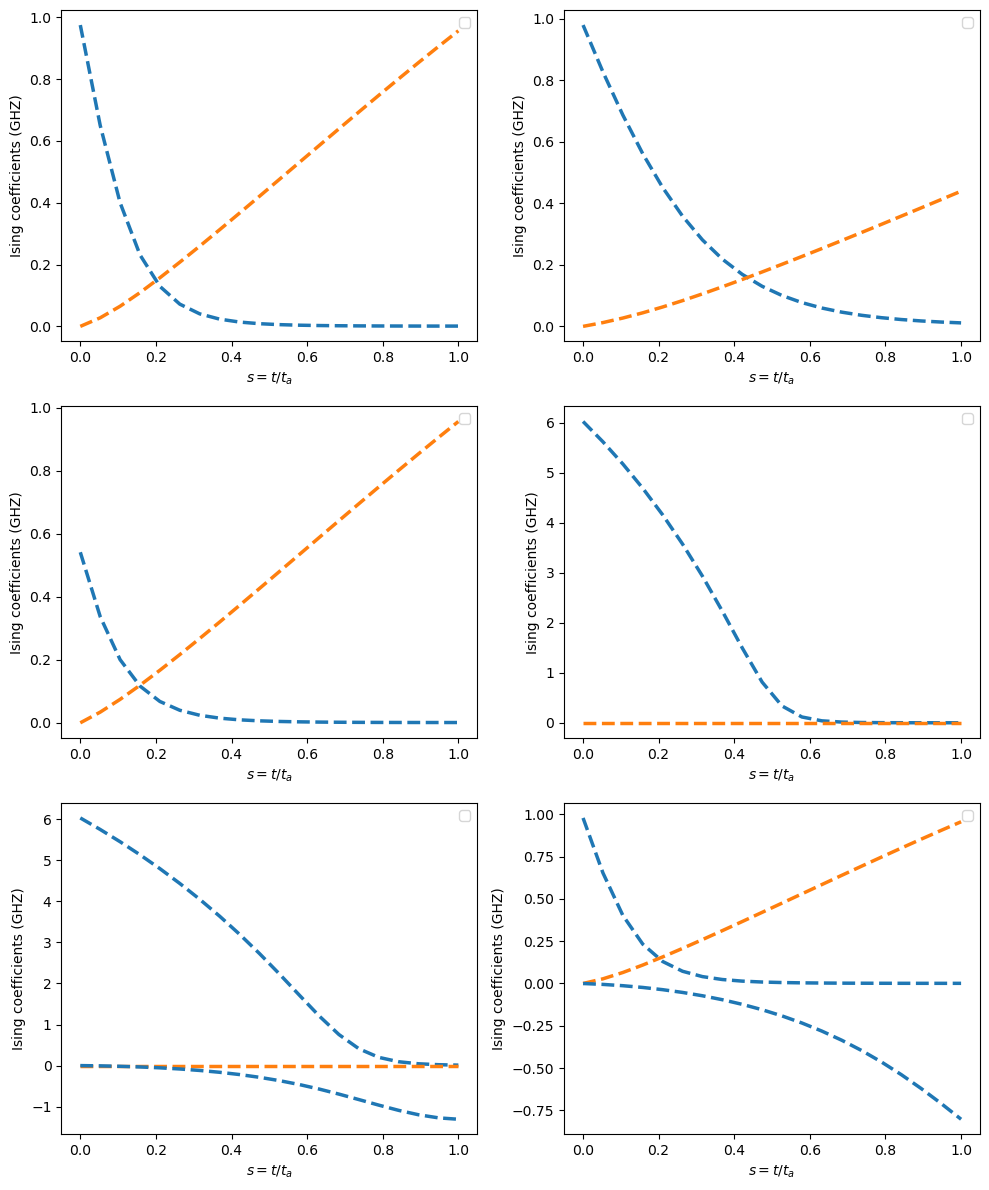

In [50]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 12))

for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    
    plt.plot(s, ising_pwsw_dict["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s, ising_pwsw_dict["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
labels = [[0, 1], [1, 2]]
for i in range(2):
    ax2 = plt.subplot(3, 2, i+5)
    
    plt.plot(s, ising_pwsw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
plt.tight_layout()
plt.show()

# Calculating circuit fluxes for a given Ising schedule 

In this part, we want to find the appropriate circuit biases that yields a desired Ising schedule that we want. For that let us use an Ising schedule that changes linearly with the anneal time. We have to construct the dictionary for this schedule, with the key assignment the same as the ones that the methods of the previous sections were outputting. The Ising coefficients should be angular frequencies in units of GHz, meaning $\omega = 2\pi f$.

In [100]:
ising_dict = {}; pts = 10
s = np.linspace(0, 1, pts)
ising_dict["points"] = pts

for i in range(nqubits):
    ising_dict["x_"+str(i)] = np.linspace(1, 0, pts)*2*np.pi

# ising_dict["x_0"] = np.linspace(1, 0, pts)*2*np.pi
# ising_dict["x_1"] = np.linspace(0.8, 0, pts)*2*np.pi
# ising_dict["x_2"] = np.linspace(0.7, 0.05, pts)*2*np.pi
# ising_dict["x_3"] = np.linspace(1, 0, pts)*2*np.pi
# ising_dict["x_4"] = np.linspace(0.8, 0, pts)*2*np.pi
# ising_dict["x_5"] = np.linspace(0.7, 0.05, pts)*2*np.pi
# ising_dict["x_6"] = np.linspace(1, 0, pts)*2*np.pi
# ising_dict["x_7"] = np.linspace(0.8, 0, pts)*2*np.pi
# ising_dict["x_8"] = np.linspace(0.7, 0.05, pts)*2*np.pi


# 0.6*Z0*Z4 + 0.6*Z3*Z7 + 0.2*Z0*Z5 + 0.2*Z3*Z8 + 0.6*Z1*Z3 + 0.6*Z4*Z6 + 
# 0.1*Z1*Z5 + 0.1*Z4*Z8 + 0.2*Z2*Z3 + 0.2*Z5*Z6 + 0.1*Z2*Z4 + 0.1*Z5*Z7 

# 4 *( - 4*Z0 - 4 * Z1 - 4 * Z2 - 4 * Z5 - 4 * Z6 -4 * Z7 - 4 * Z8 +  # done
#     2 * Z00 + 2 Z11  2 Z22 + 2 Z33 + 2 Z44 + 2 Z55 + 2 Z66 +2 Z66 + 2 Z77 + 2 Z88  # done
#     2 Z01 + 2 Z02 + 2 Z03 + 2 Z06 +
#     2 Z12 + 2 Z14 + 2 Z17 +
#     2 Z25 + 2 Z28
#     2 Z36 + 2 Z34 + 2 Z35 +
#     2 Z47 + 2 Z45
#     2 Z58 +
#     2 Z67 + 2 Z68 +
#     2 Z78
#     )

for i in range(nqubits): 
    ising_dict["z_" + str(i)] = np.linspace(0.0, -16, pts)*2*np.pi
    ising_dict["zz_" + str(i) + "," + str(i)] = np.linspace(0.0, 8, pts)*2*np.pi

for i in range(3):
    ising_dict["zz_" + str(0 + i*3) + "," + str(1+ i*3)] = np.linspace(0.0, 8, pts)*2*np.pi
    ising_dict["zz_" + str(0 + i*3) + "," + str(2+ i*3)] = np.linspace(0.0, 8, pts)*2*np.pi
    ising_dict["zz_" + str(1 + i*3) + "," + str(2 +i*3)] = np.linspace(0.0, 8, pts)*2*np.pi
    

for i in range(nqubits):
    for j in range(nqubits):
        if np.abs(j - i ) % 3 == 0: 
             ising_dict["zz_" + str(i) + "," + str(j)] = np.linspace(0.0, 4, pts)*2*np.pi
 


# 0.6*Z0*Z4 + 0.6*Z3*Z7 + 0.2*Z0*Z5 + 0.2*Z3*Z8 + 0.6*Z1*Z3 + 0.6*Z4*Z6 + 
# 0.1*Z1*Z5 + 0.1*Z4*Z8 + 0.2*Z2*Z3 + 0.2*Z5*Z6 + 0.1*Z2*Z4 + 0.1*Z5*Z7 

ising_dict["zz_0,4"] = np.linspace(0.0, 0.6, pts)*2*np.pi
ising_dict["zz_3,7"] = np.linspace(0.0, 0.6, pts)*2*np.pi
ising_dict["zz_0,5"] = np.linspace(0.0, 0.2, pts)*2*np.pi

ising_dict["zz_3,8"] = np.linspace(0.0, 0.2, pts)*2*np.pi
ising_dict["zz_1,3"] = np.linspace(0.0, 0.6, pts)*2*np.pi
ising_dict["zz_4,6"] = np.linspace(0.0, 0.6, pts)*2*np.pi

ising_dict["zz_1,5"] = np.linspace(0.0, 0.1, pts)*2*np.pi
ising_dict["zz_4,8"] = np.linspace(0.0, 0.1, pts)*2*np.pi
ising_dict["zz_2,3"] = np.linspace(0.0, 0.2, pts)*2*np.pi

ising_dict["zz_5,6"] = np.linspace(0.0, 0.2, pts)*2*np.pi
ising_dict["zz_2,4"] = np.linspace(0.0, 0.1, pts)*2*np.pi
ising_dict["zz_5,7"] = np.linspace(0.0, 0.1, pts)*2*np.pi


# ising_dict["z_0"] = np.linspace(0.0, 1, pts)*2*np.pi
# ising_dict["z_1"] = np.linspace(0, 0.8, pts)*2*np.pi
# ising_dict["z_2"] = np.linspace(0, 0.9, pts)*2*np.pi
# ising_dict["z_3"] = np.linspace(0.0, 1, pts)*2*np.pi
# ising_dict["z_4"] = np.linspace(0, 0.8, pts)*2*np.pi
# ising_dict["z_5"] = np.linspace(0, 0.9, pts)*2*np.pi
# ising_dict["z_6"] = np.linspace(0.0, 1, pts)*2*np.pi
# ising_dict["z_7"] = np.linspace(0, 0.8, pts)*2*np.pi
# ising_dict["z_8"] = np.linspace(0, 0.9, pts)*2*np.pi

# ising_dict["zz_0,1"] = -np.linspace(0.0, 0.9, pts)*2*np.pi
# ising_dict["zz_1,2"] = np.linspace(0.0, 0.8, pts)*2*np.pi
# ising_dict["zz_2,3"] = -np.linspace(0.0, 0.9, pts)*2*np.pi
# ising_dict["zz_3,4"] = np.linspace(0.0, 0.8, pts)*2*np.pi
# ising_dict["zz_4,5"] = -np.linspace(0.0, 0.9, pts)*2*np.pi
# ising_dict["zz_5,6"] = np.linspace(0.0, 0.8, pts)*2*np.pi
# ising_dict["zz_6,7"] = -np.linspace(0.0, 0.9, pts)*2*np.pi
# ising_dict["zz_7,8"] = -np.linspace(0.0, 0.9, pts)*2*np.pi

In [101]:
ising_dict.keys()

dict_keys(['points', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'z_0', 'zz_0,0', 'z_1', 'zz_1,1', 'z_2', 'zz_2,2', 'z_3', 'zz_3,3', 'z_4', 'zz_4,4', 'z_5', 'zz_5,5', 'z_6', 'zz_6,6', 'z_7', 'zz_7,7', 'z_8', 'zz_8,8', 'zz_0,1', 'zz_0,2', 'zz_1,2', 'zz_3,4', 'zz_3,5', 'zz_4,5', 'zz_6,7', 'zz_6,8', 'zz_7,8', 'zz_0,3', 'zz_0,6', 'zz_1,4', 'zz_1,7', 'zz_2,5', 'zz_2,8', 'zz_3,0', 'zz_3,6', 'zz_4,1', 'zz_4,7', 'zz_5,2', 'zz_5,8', 'zz_6,0', 'zz_6,3', 'zz_7,1', 'zz_7,4', 'zz_8,2', 'zz_8,5', 'zz_0,4', 'zz_3,7', 'zz_0,5', 'zz_3,8', 'zz_1,3', 'zz_4,6', 'zz_1,5', 'zz_4,8', 'zz_2,3', 'zz_5,6', 'zz_2,4', 'zz_5,7'])

# Circuit fluxes via numerical optimization using full SW

For this, we construct the Ising coefficients using the full SW method, and then use optimization algorithms to find fluxes that minimize the distance between calculated Ising and desired schedules. Since this uses the full SW method its computational cost scales exponentially with the number of qubits and couplers. Even worse, the algorithm will construct the full SW of the system multiple times at each point, which makes it take much longer to compute (note the wall time for the following cell). Of course this method only workds for small circuits, but nevertheless it is invoked via the `get_custom_fluxes_num` method. The `optimizer_method` argument tells what optimization algorithm to use for this routine, and experience shows `leastsq` is decent method for most cases.

In [ ]:
# This takes so much time 

# custom_flux_dict_num = circuit.get_custom_fluxes_num(ising_dict, verbose = True, optimizer_method = "leastsq")

# Circuit fluxes via pair-wise SW

This uses the pair-wise SW method to calculate the appropriate circuit biases that yields our desired schedules. For that, the qubit x and z biases are calculated so that it yields our desired single qubit Ising terms. These single qubit x and z biases are found by numerically optimizing the qubit circuit biases to find the ones that yields our desired Ising coefficients. For the coupler bias, its z-bias is always kept at degeneracy, and for its x-bias, we form pairs of qubit-coupler-qubit, construct SW for that pair and calculate the interaction between them. Then we use this as kind of "look-up table" to find the coupler x-bias that yields our desired interaction. This method only scales linearly with the number or qubit and coupler circuits, therefore it can be used for large circuits. For that we use the `get_custom_fluxes_pwsw` method of this module. The `optimizer_method` argument tells what optimization algorithm to use for single qubit flux extraction, and `leastsq` is a good method for that 

In [102]:
custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 9
point #1 single qubit residuals: 
 [ 0.19054608 -3.7678684 ] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #1, solver found solutions that are not optimal. The relative error is 30.21 % for single qubit residuals
  warnings.warn(


point #2 single qubit residuals: 
 [  0.74938269 -14.33682073] 

point #3 single qubit residuals: 
 [  1.34517363 -24.88244619] 

point #4 single qubit residuals: 
 [  1.98826447 -35.40291103] 

point #5 single qubit residuals: 
 [  2.70788356 -45.88997982] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #5, solver found solutions that are not optimal. The relative error is 82.21 % for single qubit residuals
  warnings.warn(


point #6 single qubit residuals: 
 [  3.64949226 -56.31490546] 

point #7 single qubit residuals: 
 [  5.33754806 -66.57198522] 

point #8 single qubit residuals: 
 [-83.83722813 -89.14863528] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #8, solver found solutions that are not optimal. The relative error is 136.94 % for single qubit residuals
  warnings.warn(


point #9 single qubit residuals: 
 [-340.87535154 -100.50623611] 

calculating qubit biases for qubit 2 of 9


/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 353.51 % for single qubit residuals
  warnings.warn(


point #1 single qubit residuals: 
 [ 0.19089178 -3.76690563] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #1, solver found solutions that are not optimal. The relative error is 30.20 % for single qubit residuals
  warnings.warn(


point #2 single qubit residuals: 
 [  0.75151657 -14.33441226] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #2, solver found solutions that are not optimal. The relative error is 62.77 % for single qubit residuals
  warnings.warn(


point #3 single qubit residuals: 
 [  1.34761386 -24.87860423] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #3, solver found solutions that are not optimal. The relative error is 73.78 % for single qubit residuals
  warnings.warn(


point #4 single qubit residuals: 
 [  1.99588688 -35.39733841] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #4, solver found solutions that are not optimal. The relative error is 79.11 % for single qubit residuals
  warnings.warn(


point #5 single qubit residuals: 
 [  2.7232143  -45.88250968] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #5, solver found solutions that are not optimal. The relative error is 82.19 % for single qubit residuals
  warnings.warn(


point #6 single qubit residuals: 
 [  3.6482009  -56.30704568] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #6, solver found solutions that are not optimal. The relative error is 84.15 % for single qubit residuals
  warnings.warn(


point #7 single qubit residuals: 
 [  5.35155548 -66.56150752] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #7, solver found solutions that are not optimal. The relative error is 85.39 % for single qubit residuals
  warnings.warn(


point #8 single qubit residuals: 
 [-84.59401304 -89.1498048 ] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #8, solver found solutions that are not optimal. The relative error is 137.53 % for single qubit residuals
  warnings.warn(


point #9 single qubit residuals: 
 [-452.32797105 -100.52380371] 

calculating qubit biases for qubit 3 of 9


/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 460.92 % for single qubit residuals
  warnings.warn(


point #1 single qubit residuals: 
 [ 0.1909269  -3.76690362] 

point #2 single qubit residuals: 
 [  0.7514014  -14.33441776] 

point #3 single qubit residuals: 
 [  1.34700418 -24.87863649] 

point #4 single qubit residuals: 
 [  1.99513055 -35.39738021] 

point #5 single qubit residuals: 
 [  2.71504016 -45.88299423] 

point #6 single qubit residuals: 
 [  3.65232532 -56.30677521] 

point #7 single qubit residuals: 
 [  5.35667257 -66.56109158] 

point #8 single qubit residuals: 
 [-82.88610285 -89.14726403] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #8, solver found solutions that are not optimal. The relative error is 136.21 % for single qubit residuals
  warnings.warn(


point #9 single qubit residuals: 
 [-431.91008995 -100.52178908] 

calculating qubit biases for qubit 4 of 9


/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 441.11 % for single qubit residuals
  warnings.warn(


point #1 single qubit residuals: 
 [ 0.19088599 -3.7669057 ] 

point #2 single qubit residuals: 
 [  0.75117747 -14.33442953] 

point #3 single qubit residuals: 
 [  1.34981508 -24.87848362] 

point #4 single qubit residuals: 
 [  1.99530129 -35.39737024] 

point #5 single qubit residuals: 
 [  2.71388489 -45.88306306] 

point #6 single qubit residuals: 
 [  3.66254917 -56.3061098 ] 

point #7 single qubit residuals: 
 [  5.34829198 -66.56176919] 

point #8 single qubit residuals: 
 [-85.072383   -89.15051286] 



/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #8, solver found solutions that are not optimal. The relative error is 137.90 % for single qubit residuals
  warnings.warn(


## Output of methods 

The output of both methods is a dictionary that included the calculated circuit fluxes. 

In [89]:
custom_flux_dict_pwsw.keys()

dict_keys(['points', 'phix_0', 'phiz_0', 'phix_1', 'phiz_1', 'phix_2', 'phiz_2'])

Below we plot the extracted circuit biases using these methods, where the solid lines are calculated using numerical method, while the dashed lines are calculated using the pair-wise method.

ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

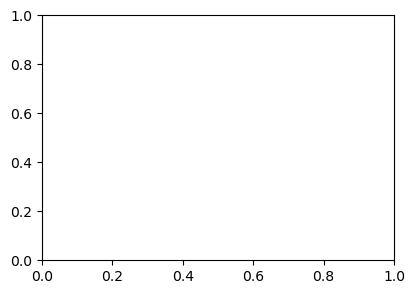

In [74]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
#    plt.plot(s, custom_flux_dict_num["phix_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
#    plt.plot(s, custom_flux_dict_num["phiz_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)
# plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
#    plt.plot(s, custom_flux_dict_num["phix_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
#    plt.plot(s, custom_flux_dict_num["phiz_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
plt.show()

# DQA

In this section we are looking for implementing DQA for an arbitrary system 

In [53]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import cas as cas
import importlib
import pickle

In [54]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)

elements = [qubit0, coupler01, qubit1]

# couple qubits in a chain

m = 65; m_mat = np.zeros((3,3));
m_mat[0, 1] = m; m_mat[1, 2] = -m;
m_mat = -(m_mat + m_mat.T)

trunc_vec = np.array([7, 4, 7])

circuit = cas.AnnealingCircuit(elements, m_mat, trunc_vec)

/Users/enriquenb/opt/anaconda3/envs/Qilimanjaro-ETH-Hackathon/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [57]:
schedule_dict = {}; pts = 10;
s = np.linspace(0, 1, pts)
schedule_dict["points"] = pts

s1 = 0.1; # location of first minimum gap
Delta_1 = 0.05*2*np.pi; # size of the first minimum gap
hx1 = 0.5*2*np.pi; hx2 = 1*2*np.pi;
hz1 = 0.5*2*np.pi; hz2 = 0.8*2*np.pi;
J = 0.7*2*np.pi

schedule_dict["x_0"] = hx1*np.array([(Delta_1/2/hx1 - 1)*(s/s1) + 1 if s<=s1 else (Delta_1/2/hx1)*((s-1)/(s1-1)) for s in s])
schedule_dict["z_0"] = hz1*np.array([0 if s<=s1 else (s-s1)/(1-s1) for s in s])

schedule_dict["x_1"] = hx2*np.array([1 if s<=s1 else ((s-1)/(s1-1)) for s in s])
schedule_dict["z_1"] = hz2*np.array([0 if s<=s1 else (s-s1)/(1-s1) for s in s])

schedule_dict["zz_0,1"] = J*np.array([0 if s<=s1 else (s-s1)/(1-s1) for s in s])

In [59]:
custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(schedule_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 2
point #9 single qubit residuals: 
 [-9.26002257e-02  6.61752204e-05] 

calculating qubit biases for qubit 2 of 2


/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 2.95 % for single qubit residuals
  warnings.warn(


point #9 single qubit residuals: 
 [-9.34679451e-02  7.22503019e-05] 


 calculating coupler bias for coupler 1 of 1


/Users/enriquenb/Documents/GitHub/CAS/cas/elements.py:617: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.86 % for single qubit residuals
  warnings.warn(
